In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [4]:
from tqdm import tqdm

In [5]:
import freqepid

# 1. load data

In [6]:
GPi = np.load('data/GPi.npz')

In [7]:
data = pd.read_feather('data/CovidCastStateAdj_2.feather').iloc[:,:-1]

## comparison with unadjusted data

In [8]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

In [9]:
data_raw = pd.read_feather('data/CovidCastState.feather').iloc[:,:-1]

In [50]:
regions = ['nj', 'ca', 'ne', 'nh']

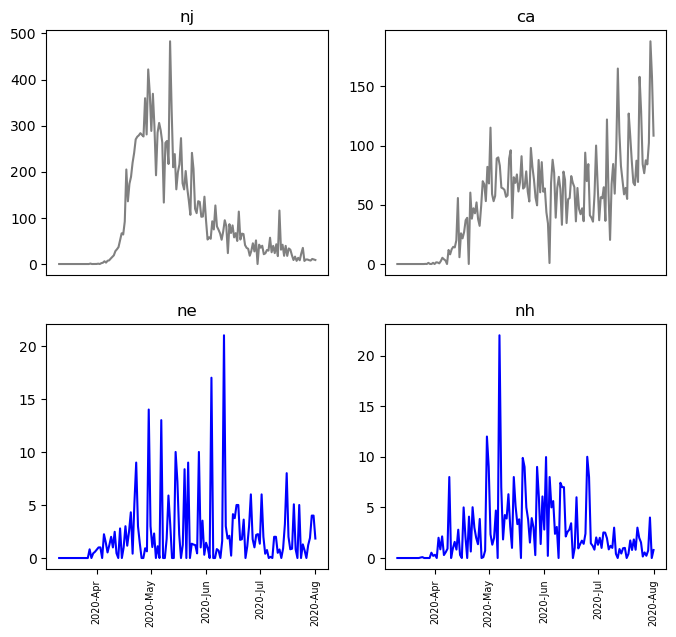

In [53]:
plt.figure(figsize=(8,7))

for i, r in enumerate(regions):
    plt.subplot(2,2,i+1)
    
    data_i = data[data.geo_value == r]
    data_i_raw = data_raw[data_raw.geo_value == r]
    
    if i < 2:
        plt.plot(data_i.time_value, np.maximum(data_i.deaths, 0), color='grey', label='adjusted')
        # plt.plot(data_i_raw.time_value, np.maximum(data_i_raw.deaths, 0), color='grey', label='raw')
        plt.title(r)
    
        plt.xticks([],[])
    
    if i >= 2:
        plt.plot(data_i.time_value, np.maximum(data_i.deaths, 0), color='blue', label='adjusted')
        # plt.plot(data_i_raw.time_value, np.maximum(data_i_raw.deaths, 0), color='grey', label='raw')
        plt.title(r)
        
        dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
        plt.gca().xaxis.set_major_formatter(dtFmt) 
        # show every 12th tick on x axes
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)
    
    # if i == 0:
        # plt.legend()

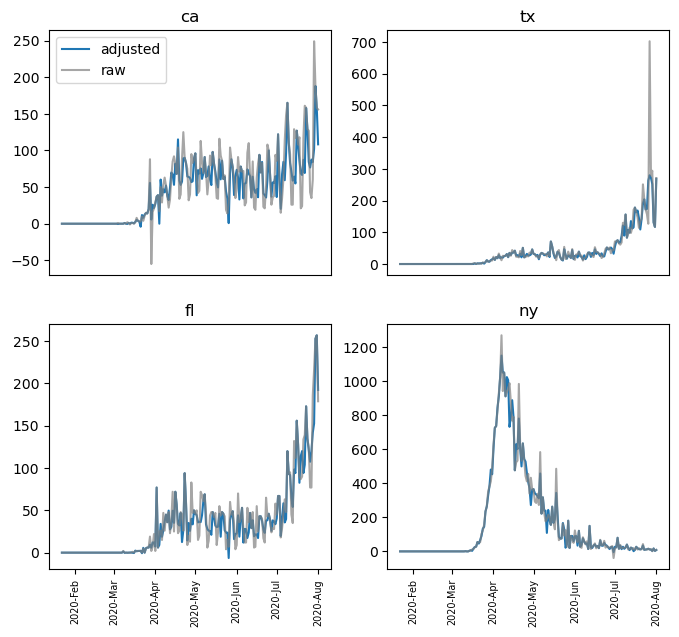

In [11]:
plt.figure(figsize=(8,7))

for i, r in enumerate(regions):
    plt.subplot(2,2,i+1)
    
    data_i = data[data.geo_value == r]
    data_i_raw = data_raw[data_raw.geo_value == r]
    
    plt.plot(data_i.time_value, data_i.deaths, label='adjusted')
    plt.plot(data_i_raw.time_value, data_i_raw.deaths, color='grey', alpha=0.7, label='raw')
    plt.title(r)
    
    if i < 2:
        plt.xticks([],[])
    
    if i >= 2:
        dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
        plt.gca().xaxis.set_major_formatter(dtFmt) 
        # show every 12th tick on x axes
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)
    
    if i == 0:
        plt.legend()

## truncation

In [12]:
data = data.groupby("geo_value").filter(lambda x: x.deaths.max() > 20)

In [13]:
deaths_raw = data.groupby("geo_value").apply(lambda x: sum(x.deaths))

In [14]:
data = data.groupby("geo_value", group_keys=False).apply(lambda x: 
     x[x.time_value > x[x.deaths.cumsum() > 10].time_value.min() - pd.Timedelta(30, unit='D')])

In [15]:
deaths_trunc = data.groupby("geo_value").apply(lambda x: sum(x.deaths))

In [16]:
deaths_raw - deaths_trunc

geo_value
al    0.0
az    0.0
ca    0.0
co    0.0
ct    0.0
fl    0.0
ga    0.0
il    0.0
in    0.0
la    0.0
ma    0.0
md    0.0
mi    0.0
mn    0.0
mo    0.0
ms    0.0
nc    0.0
ne    0.0
nh    0.0
nj    0.0
nv    0.0
ny    0.0
oh    0.0
pa    0.0
ri    0.0
sc    0.0
tn    0.0
tx    0.0
va    0.0
wa    0.0
dtype: float64

In [84]:
regions = np.array(data['geo_value'].unique())

In [85]:
regions, len(regions)

(array(['al', 'az', 'ca', 'co', 'ct', 'fl', 'ga', 'il', 'in', 'la', 'ma',
        'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nh', 'nj', 'nv', 'ny',
        'oh', 'pa', 'ri', 'sc', 'tn', 'tx', 'va', 'wa'], dtype=object),
 30)

In [19]:
ivs = [5]

In [20]:
np.array(data.columns)[ivs]

array(['full_time_work_prop'], dtype=object)

In [21]:
num_region = len(regions)
d = len(ivs)+1

# 2. EDA

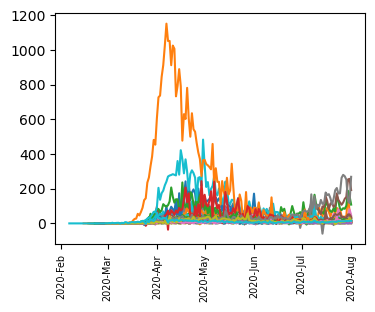

In [22]:
plt.figure(figsize=(4,3))

for r in regions:
    plt.plot(np.array(data[data.geo_value == r].time_value),
             np.array(data[data.geo_value == r].deaths), label=r)
# plt.legend()

dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)

plt.show()

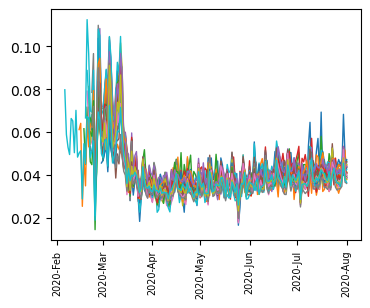

In [23]:
plt.figure(figsize=(4,3))
for i, iv in enumerate(ivs):
    # plt.subplot(2,2,i+1)
    # plt.title(np.array(data.columns)[iv]); # plt.xlabel('days')
    for r in regions:
        plt.plot(np.array(data[data.geo_value == r].time_value),
                 np.array(data[data.geo_value == r].iloc[:,iv]),
                 linewidth=1)

dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)        

plt.show()

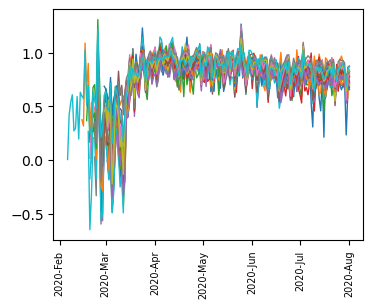

In [24]:
plt.figure(figsize=(4,3))
for i, iv in enumerate(ivs):
    # plt.subplot(2,2,i+1)
    # plt.title(np.array(data.columns)[iv]); # plt.xlabel('days')
    for r in regions:
        plt.plot(np.array(data[data.geo_value == r].time_value),
                 np.array(data[data.geo_value == r].iloc[:,iv]) * (-20) + 1.6,
                 linewidth=1)

dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)        

plt.show()

# 3. fit

In [25]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## parameters

In [27]:
lamda = 0.1
num_iter = 1000
num_MC = 1000

In [28]:
T0 = 40
K = 6.5
alpha = 1

In [29]:
model = freqepid.Model(
    np.concatenate([[0],GPi['g']]), np.concatenate([[0],GPi['pi']]), 
    alpha, K, T0, 'nbinom'
)

In [30]:
window_size = 5

## fit

In [30]:
ns_mle = np.zeros(num_region)
ms_mle = np.zeros(num_region)
bs_mle = np.zeros((num_region,d))
Vs_mle = np.zeros((num_region,d+2,d+2))

In [31]:
bs_EE = np.zeros((num_region,d))
Vs_EE = np.zeros((num_region,d,d))

In [92]:
for i_region, r \
in tqdm(enumerate(regions), desc='REG', total=len(regions)):
    
    # data
    data_r = data.query("geo_value == '%s'"%r)
    Y = data_r.deaths.values
    A = data_r.full_time_work_prop.values * (-20) + 1.6
    T = Y.shape[0]   

    # estimation of pi
    X_pi = np.stack([A[:-1], Y[:-1]], -1)
    Y_pi = np.array(A[1:])
    pi_fit = LinearRegression().fit(X_pi, Y_pi)
    shat_pi = np.sqrt(np.mean((Y_pi - pi_fit.predict(X_pi))**2))
    
    # estimation of varpi
    X_varpi = np.stack([A[:-1]], -1)
    varpi_fit = LinearRegression().fit(X_varpi, Y_pi)
    shat_varpi = np.sqrt(np.mean((Y_pi - varpi_fit.predict(X_varpi))**2))
    
    # estimation of beta: setup
    g = np.zeros(T+T0)
    g[:min(GPi['g'].shape[0], T+T0)] =\
        np.concatenate([[0],GPi['g']])[:min(GPi['g'].shape[0], T+T0)]

    pi = np.zeros(T+T0)
    pi[:min(GPi['pi'].shape[0], T+T0)] =\
        np.concatenate([[0],GPi['pi']])[:min(GPi['pi'].shape[0], T+T0)]
    
    Pi = alpha * np.where(
        np.arange(T)[:,None] - np.arange(T) < 0, 0,
        pi[np.maximum(0, np.arange(T)[:,None] - np.arange(T))],
    )
    Pi0 = alpha * np.where(
        np.arange(T)[:,None] - np.arange(-T0,0) < 0, 0,
        pi[np.maximum(0, np.arange(T)[:,None] - np.arange(-T0,0))],
    )
    
    G = np.where(
        np.arange(T)[:,None] - np.arange(T) < 0, 0,
        g[np.maximum(0, np.arange(T)[:,None] - np.arange(T))],
    )
    G0 = np.where(
        np.arange(T)[:,None] - np.arange(-T0,0) < 0, 0,
        g[np.maximum(0, np.arange(T)[:,None] - np.arange(-T0,0))],
    )
    
    ws = stats.norm.pdf(Y_pi, varpi_fit.predict(X_varpi), shat_varpi) \
         / stats.norm.pdf(Y_pi, pi_fit.predict(X_pi), shat_pi)
    Ws = np.cumprod(np.concatenate([[1], ws], -1), -1)
    # Ws = np.cumprod(np.concatenate([[1], ws[:window_size], ws[window_size:]/ws[:-window_size]], -1), -1)
    hs = np.stack([
        np.full(T, 1),
        A - np.concatenate([[0], varpi_fit.predict(X_varpi)]),
        (A - np.concatenate([[0], varpi_fit.predict(X_varpi)]))**2
    ])
    
    # estimation of beta: initialize
    X_mu = np.stack([np.full(T, 1), A], -1)
    Y_mu = Y
    
    nmle, mmle, bmle, ll =\
    model.fit(X_mu, Y_mu, n_iter=100, step_size=1,
              history=False, verbose=False)
    
    ns_mle[i_region] = nmle
    ms_mle[i_region] = mmle
    bs_mle[i_region,:] = bmle
    
    Ihat_dth, Ihat_hac, Ihat_sdw =\
    model.inference(X_mu, Y_mu, nmle, mmle, bmle)
    
    Vs_mle[i_region] = la.pinv(Ihat_sdw)
    
    I0 = np.full(T0, np.exp(mmle))
    bhat = bmle
    
    # estimation of beta: Newton's method
    for i in np.arange(num_iter):
        XAs_MC = X_mu

        R_MC = K /(1 + np.exp(- XAs_MC @ bhat))
        dRdb_MC = (R_MC * (1 - R_MC/K)) * XAs_MC.T

        L_MC = R_MC[...,None] * G
        L0_MC = R_MC[...,None] * G0
        dLdb_MC = dRdb_MC[...,None] * G
        dL0db_MC = dRdb_MC[...,None] * G0

        inv_ImL_MC = np.linalg.inv(np.eye(T) - L_MC)

        I_MC = inv_ImL_MC @ (L0_MC @ I0)
        EY_MC = Pi @ I_MC + Pi0 @ I0
        dIdb_MC = inv_ImL_MC @ (dLdb_MC @ I_MC[:,None] + dL0db_MC @ I0[:,None])
        dEYdb_MC = (Pi @ dIdb_MC)[...,0]

        psi = EY_MC
        dpsidb = dEYdb_MC
        
        EEt = (Y - psi) * hs * Ws
        dEEtdb = - dpsidb * (hs * Ws)[:,None,:]
        EE = np.sum(EEt, -1)
        dEEdb = np.sum(dEEtdb, -1)
        
        db = np.linalg.lstsq(dEEdb, EE)[0]
        db = db / np.maximum(1, np.sqrt(np.sum(db**2)))
        bhat = bhat - lamda * db

    bs_EE[i_region] = bhat
    
    L_HAC = np.floor(4*(T/100)**(2/9))
    w_HAC = np.maximum(1 - np.abs(
        np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)
    
    Ihat_hac = (EEt - np.mean(EEt, -1)[:,None]) @ w_HAC @ (EEt - np.mean(EEt, -1)[:,None]).T
    Ihat_sdw = dEEdb.T @ la.pinv(Ihat_hac) @ dEEdb
    
    Vs_EE[i_region] = la.pinv(Ihat_sdw)

REG: 100%|███████████████████████████████████████████████████████████| 30/30 [03:13<00:00,  6.44s/it]


In [45]:
np.savez('result_delphi_EE.npz',
         ns_mle = ns_mle, ms_mle = ms_mle, 
         bs_mle = bs_mle, Vs_mle = Vs_mle,
         bs_EE = bs_EE, Vs_EE = Vs_EE)

## plots

In [33]:
locals().update(np.load('result_delphi_EE.npz'))

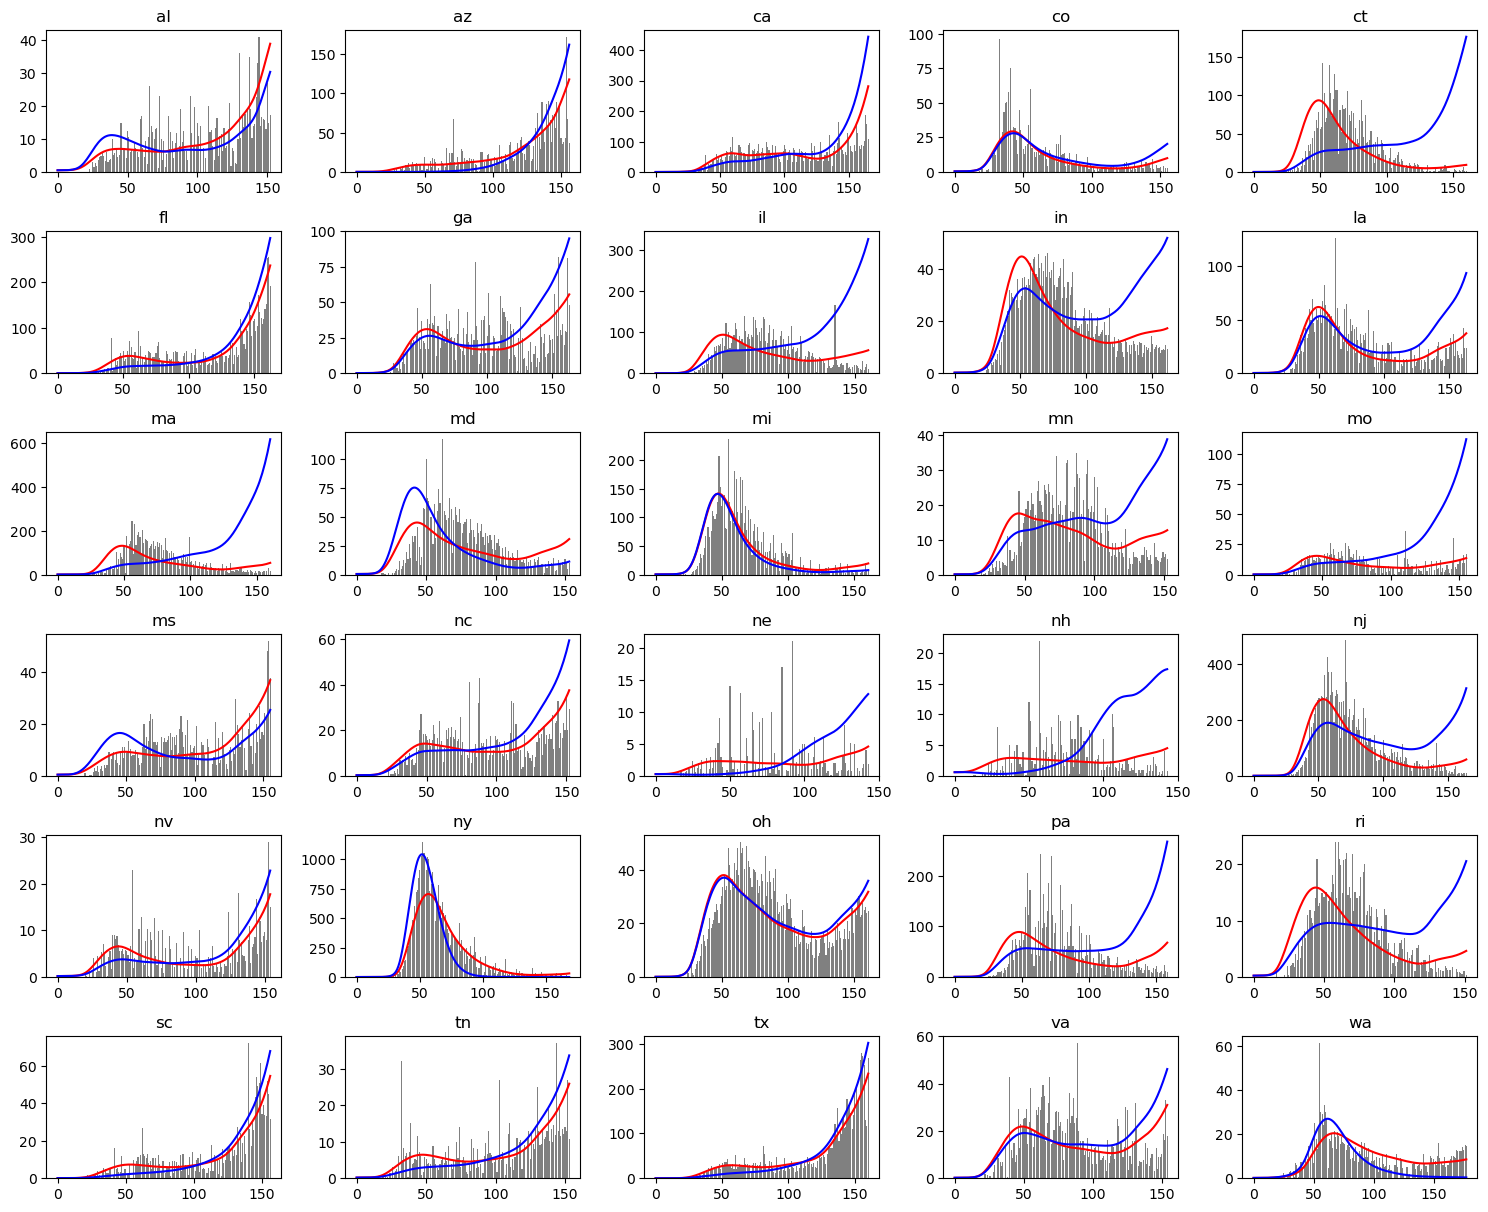

In [34]:
plt.figure(figsize=(15, int(len(regions)/5+1)*2))

for i, r in enumerate(regions):
    plt.subplot(int(len(regions)/5+1),5,i+1)
    
    data_r = data.query("geo_value == '%s'"%r)
    Y = data_r.deaths.values
    A = data_r.full_time_work_prop.values * (-20) + 1.6
    T = Y.shape[0]  
    
    X_mu = np.stack([np.full(T, 1), A], -1)

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(X_mu, ms_mle[i], bs_mle[i]), color='red')
    plt.plot(model.predict_EY(X_mu, ms_mle[i], bs_EE[i]), color='blue')
    plt.title('%s'%r)
    plt.ylim(bottom=0)
    
plt.tight_layout()

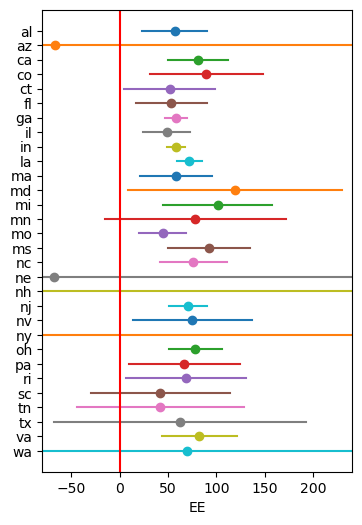

In [91]:
plt.figure(figsize=(4,6))

k=0

plt.gca().invert_yaxis()
for i, r in enumerate(regions):
    se2 = np.diag(Vs_EE[i])[k+1] 
    if se2 > 0:
        plt.plot([(bs_EE[i,k+1]-2*np.sqrt(se2))*(-20), 
                  (bs_EE[i,k+1]+2*np.sqrt(se2))*(-20)],
                 [i, i], color='C%d'%i)
    else:
        plt.axhline(y=i, color='C%d'%i)
    plt.scatter(bs_EE[i,k+1]*(-20), i, color='C%d'%i)

plt.axvline(x=0, color='red')
plt.xlim((-80,240))
plt.yticks(np.arange(len(regions)), regions) 
plt.xlabel('EE')
    
plt.show()

Text(0.5, 1.0, 'EE')

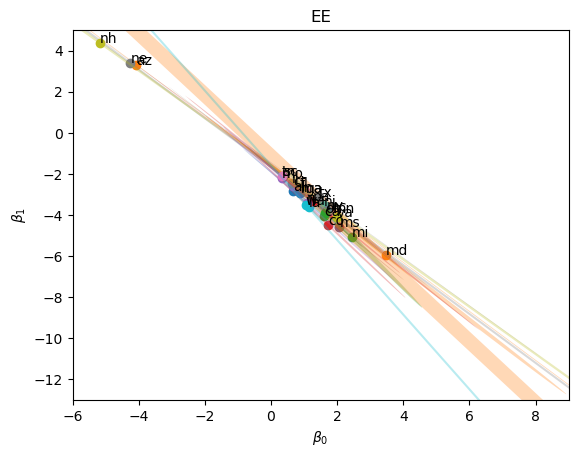

In [36]:
for i_region, (r, bmle, Vmle) \
in enumerate(zip(regions, bs_EE, Vs_EE)):
#     if r in ['nh', 'wa','az', 'ne', 'ny']:
#         continue
    p = plt.scatter(*bmle, label="%d"%i_region)
    plt.annotate(r, bmle)
    freqepid.confidence_ellipse(
        bmle, Vmle, n_std=np.sqrt(stats.chi2(2).ppf(0.95)),
        facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); # plt.legend()
plt.xlim(-6, 9); plt.ylim(-13, 5); plt.title('EE')

# 3. EBCR

In [54]:
ths_EE = bs_EE

In [55]:
result_ebcr = freqepid.EBCR(ths_EE, Vs_EE, num_mc=1000)

In [56]:
result_ebcr.th_o

array([ 1.13252842, -3.1954545 ])

In [57]:
result_ebcr.Phi2

array([[-63.52273595,  74.19409322],
       [ 74.19409322, -87.27766064]])

In [58]:
ths_eb = result_ebcr.ths_eb

In [59]:
Vs_eb = result_ebcr.covs_eb

In [60]:
chi_pa = result_ebcr.chi_pa(0.05)

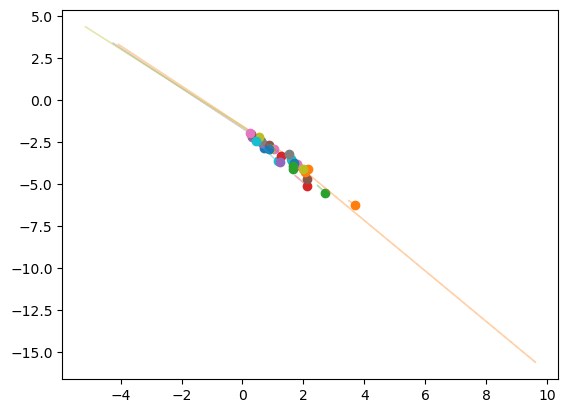

In [61]:
for i in np.arange(num_region):
    p = plt.scatter(*ths_eb[i,:])
    plt.arrow(*ths_EE[i,:], *(ths_eb[i,:]-ths_EE[i,:]), width=0.01, 
             length_includes_head=True,
             color=p.get_facecolor(), alpha=0.3)

(-13.0, 5.0)

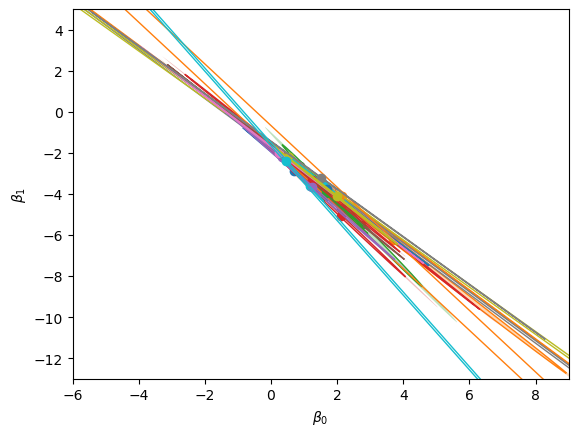

In [62]:
for i in np.arange(num_region):
    p = plt.scatter(*ths_eb[i])
    freqepid.confidence_ellipse(
        ths_eb[i,:], Vs_eb[i,:,:], n_std = chi_pa,
        facecolor=p.get_facecolor(), alpha=0.3)
    freqepid.confidence_ellipse(
        ths_EE[i,:], Vs_EE[i,:,:], n_std = chi_pa,
        edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))
plt.xlim(-6, 9); plt.ylim(-13, 5)

## robust CR

In [63]:
rho_pa = np.zeros(num_region)
rho_l = np.zeros(num_region)

In [64]:
for i in np.arange(num_region):
    start_iter = time.time()
    
    rho_pa[i] = result_ebcr.cv.rho(chi_pa, result_ebcr.m2s[i],
                                   result_ebcr.m4s[i]+1e-2)['alpha']
    
    rho_l[i] = result_ebcr.cv.rho_l(chi_pa, result_ebcr.m2s[i],
                                    result_ebcr.m4s[i])['alpha']
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 0.62 sec.
region 1 finished, lapse: 0.49 sec.
region 2 finished, lapse: 0.49 sec.
region 3 finished, lapse: 0.48 sec.
region 4 finished, lapse: 0.49 sec.
region 5 finished, lapse: 0.48 sec.
region 6 finished, lapse: 0.48 sec.
region 7 finished, lapse: 0.49 sec.
region 8 finished, lapse: 0.49 sec.
region 9 finished, lapse: 0.47 sec.
region 10 finished, lapse: 0.48 sec.
region 11 finished, lapse: 0.48 sec.
region 12 finished, lapse: 0.48 sec.
region 13 finished, lapse: 0.48 sec.
region 14 finished, lapse: 0.48 sec.
region 15 finished, lapse: 0.48 sec.
region 16 finished, lapse: 0.48 sec.
region 17 finished, lapse: 0.48 sec.
region 18 finished, lapse: 0.48 sec.
region 19 finished, lapse: 0.48 sec.
region 20 finished, lapse: 0.48 sec.
region 21 finished, lapse: 0.48 sec.
region 22 finished, lapse: 0.48 sec.
region 23 finished, lapse: 0.48 sec.
region 24 finished, lapse: 0.48 sec.
region 25 finished, lapse: 0.48 sec.
region 26 finished, lapse: 0.48 sec.
region 27 f

In [65]:
rho_pa

array([-1.32703611e-02, -6.65563370e+05, -4.98320695e-02, -3.08503036e+00,
       -2.40657656e-01, -4.74454109e-02,  5.00794453e-02,  2.77970620e-02,
        4.94332422e-02,  2.26514975e-02, -1.34879872e-01, -7.55908500e+00,
       -6.07697677e+00, -2.82124463e+00, -3.59551797e-02, -7.05559617e-02,
       -2.39095832e-02, -3.96267780e+06, -2.36352799e+14,  4.42859291e-02,
       -8.88468141e-01, -4.18953318e+07, -4.67975043e-02, -3.77907505e-01,
       -1.43649925e+00, -1.11439410e+00, -2.99615066e+00, -3.37538917e+01,
       -3.59804327e-02, -9.53691866e+09])

In [66]:
rho_l

array([0.05106803, 0.05106803, 0.05106803, 0.05106803, 0.05106803,
       0.05106803, 0.05106803, 0.05106803, 0.05106803, 0.05106803,
       0.05106803, 0.05106803, 0.05106803, 0.05106803, 0.05106803,
       0.05106803, 0.05106803, 0.05106803, 0.05106803, 0.05106803,
       0.05106803, 0.05106803, 0.05106803, 0.05106803, 0.05106803,
       0.05106803, 0.05106803, 0.05106803, 0.05106803, 0.05106803])

In [67]:
chi_eb = np.zeros(num_region)

In [68]:
for i in np.arange(num_region):
    start_iter = time.time()
    
    chi_eb[i] = result_ebcr.chi_eb(i, 0.05, linear=True)
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

/home/hbong/_research/freqepid/freqepid/cv.py:227: RuntimeWarning: divide by zero encountered in scalar divide
  elif 1/m2 < self.tol and np.isfinite(m4):


region 0 finished, lapse: 5.50 sec.
region 1 finished, lapse: 5.34 sec.
region 2 finished, lapse: 5.35 sec.
region 3 finished, lapse: 5.34 sec.
region 4 finished, lapse: 5.36 sec.
region 5 finished, lapse: 5.34 sec.
region 6 finished, lapse: 5.35 sec.
region 7 finished, lapse: 5.35 sec.
region 8 finished, lapse: 5.34 sec.
region 9 finished, lapse: 5.34 sec.
region 10 finished, lapse: 5.34 sec.
region 11 finished, lapse: 5.36 sec.
region 12 finished, lapse: 5.34 sec.
region 13 finished, lapse: 5.34 sec.
region 14 finished, lapse: 5.46 sec.
region 15 finished, lapse: 5.35 sec.
region 16 finished, lapse: 5.35 sec.
region 17 finished, lapse: 5.36 sec.
region 18 finished, lapse: 5.35 sec.
region 19 finished, lapse: 5.34 sec.
region 20 finished, lapse: 5.33 sec.
region 21 finished, lapse: 5.34 sec.
region 22 finished, lapse: 5.34 sec.
region 23 finished, lapse: 5.34 sec.
region 24 finished, lapse: 5.33 sec.
region 25 finished, lapse: 5.34 sec.
region 26 finished, lapse: 5.36 sec.
region 27 f

In [69]:
chi_eb

array([2.45655376, 2.45655376, 2.45655376, 2.45655376, 2.45655376,
       2.45655376, 2.45655376, 2.45655376, 2.45655376, 2.45655376,
       2.45655376, 2.45655376, 2.45655376, 2.45655376, 2.45655376,
       2.45655376, 2.45655376, 2.45655376, 2.45655376, 2.45655376,
       2.45655376, 2.45655376, 2.45655376, 2.45655376, 2.45655376,
       2.45655376, 2.45655376, 2.45655376, 2.45655376, 2.45655376])

In [70]:
rho_eb = np.zeros(num_region)

In [71]:
for i in np.arange(num_region):
    start_iter = time.time()
    
#     rho_eb[i] = result_ebcr.cv.rho(chi_pa, result_ebcr.m2s[i],
#                                    result_ebcr.m4s[i]+1e-2)['alpha']
    
    rho_eb[i] = result_ebcr.cv.rho_l(chi_eb[i], result_ebcr.m2s[i],
                                    result_ebcr.m4s[i])['alpha']
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 0.39 sec.
region 1 finished, lapse: 0.38 sec.
region 2 finished, lapse: 0.38 sec.
region 3 finished, lapse: 0.38 sec.
region 4 finished, lapse: 0.38 sec.
region 5 finished, lapse: 0.38 sec.
region 6 finished, lapse: 0.38 sec.
region 7 finished, lapse: 0.38 sec.
region 8 finished, lapse: 0.38 sec.
region 9 finished, lapse: 0.38 sec.
region 10 finished, lapse: 0.38 sec.
region 11 finished, lapse: 0.39 sec.
region 12 finished, lapse: 0.38 sec.
region 13 finished, lapse: 0.38 sec.
region 14 finished, lapse: 0.38 sec.
region 15 finished, lapse: 0.39 sec.
region 16 finished, lapse: 0.39 sec.
region 17 finished, lapse: 0.38 sec.
region 18 finished, lapse: 0.38 sec.
region 19 finished, lapse: 0.38 sec.
region 20 finished, lapse: 0.38 sec.
region 21 finished, lapse: 0.39 sec.
region 22 finished, lapse: 0.39 sec.
region 23 finished, lapse: 0.39 sec.
region 24 finished, lapse: 0.38 sec.
region 25 finished, lapse: 0.39 sec.
region 26 finished, lapse: 0.39 sec.
region 27 f

In [72]:
rho_eb

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

(-13.0, 5.0)

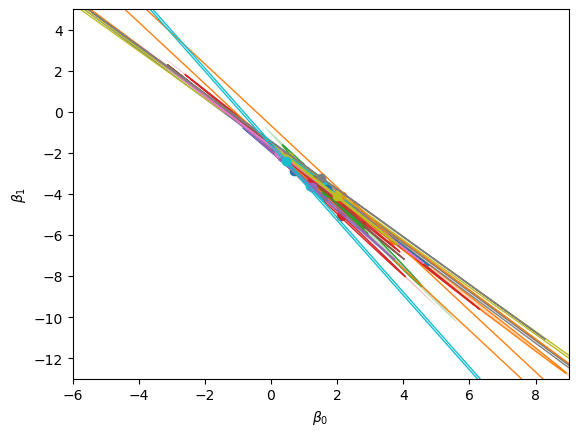

In [73]:
for i in np.arange(num_region):
    p = plt.scatter(*ths_eb[i])
    freqepid.confidence_ellipse(
        ths_eb[i], Vs_eb[i], n_std = chi_eb[i],
        facecolor=p.get_facecolor(), alpha=0.3)
    freqepid.confidence_ellipse(
        ths_EE[i], Vs_EE[i], n_std = chi_pa,
        edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))
plt.xlim(-6, 9); plt.ylim(-13, 5)

In [74]:
# plt.figure(figsize=(12,9))

# plt.subplot(1,2,1)
# plt.gca().invert_yaxis()
# for i, r in enumerate(regions):
#     se2 = np.diag(Vs_mle[i])[k+3]
#     if se2 > 0:
#         plt.plot([bs_mle[i,k+1]-chi_pa*np.sqrt(se2), 
#                   bs_mle[i,k+1]+chi_pa*np.sqrt(se2)],
#                  [i, i], color='C%d'%i)
#     else:
#         plt.axhline(y=i, color='C%d'%i)
#     plt.scatter(bs_mle[i,k+1], i, color='C%d'%i)

# plt.axvline(x=0, color='red')
# plt.yticks(np.arange(len(regions)), regions)
# plt.xlim(-20,20)

# plt.subplot(1,2,2)
# plt.gca().invert_yaxis()
# for i, r in enumerate(regions):
#     se2 = np.diag(covs_eb[i])[k+2]
#     if se2 > 0:
#         plt.plot([ths_eb[i,k+2]-chi_eb[i]*np.sqrt(se2), 
#                   ths_eb[i,k+2]+chi_eb[i]*np.sqrt(se2)],
#                  [i, i], color='C%d'%i)
#     else:
#         plt.axhline(y=i, color='C%d'%i)
#     plt.scatter(ths_eb[i,k+2], i, color='C%d'%i)

# plt.axvline(x=0, color='red')
# plt.yticks(np.arange(len(regions)), regions)
# plt.xlim(-20,20)

# plt.show()

In [75]:
# argsort_Y = np.argsort([np.max(Y) for Y in Ys_raw])

In [76]:
# argsort_T = np.argsort([Y.shape[0] for Y in Ys_raw])

In [77]:
# argsort_se = np.argsort([np.diag(Vs_mle[i])[2] for i in np.arange(num_region)])[::-1]

In [86]:
argsort_se = np.arange(num_region)[::-1].astype(int)

In [87]:
regions

array(['al', 'az', 'ca', 'co', 'ct', 'fl', 'ga', 'il', 'in', 'la', 'ma',
       'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nh', 'nj', 'nv', 'ny',
       'oh', 'pa', 'ri', 'sc', 'tn', 'tx', 'va', 'wa'], dtype=object)

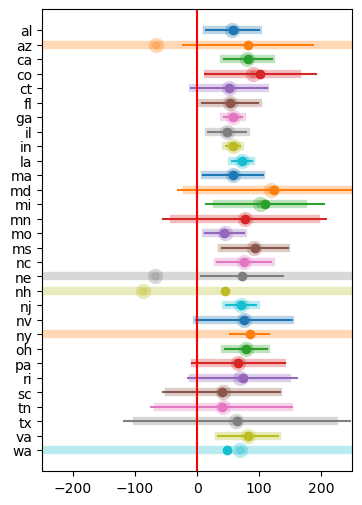

In [90]:
plt.figure(figsize=(4,6))

for j, i in enumerate(argsort_se):
    se2 = np.diag(Vs_EE[i])[-1]
    if se2 > 0:
        plt.plot(np.array([ths_EE[i,-1]-chi_pa*np.sqrt(se2), 
                  ths_EE[i,-1]+chi_pa*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i, alpha=0.3, linewidth=6)
    else:
        plt.axhline(y=j, color='C%d'%i, alpha=0.3, linewidth=6)
    plt.scatter(ths_EE[i,-1]*(-20), j, color='C%d'%i, alpha=0.3, linewidth=5)

    se2 = np.diag(Vs_eb[i])[-1]
    if se2 > 0:
        plt.plot(np.array([ths_eb[i,-1]-chi_eb[i]*np.sqrt(se2), 
                  ths_eb[i,-1]+chi_eb[i]*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i)
    else:
        plt.axhline(y=j, color='C%d'%i)
    plt.scatter(ths_eb[i,-1]*(-20), j, color='C%d'%i)

plt.axvline(x=0, color='red')
plt.yticks(np.arange(len(regions)), regions[argsort_se])
plt.xlim(-250,250)

plt.show()

## freqepid results

In [129]:
result_freqepid = np.load('result_delphi_ML.npz')

In [130]:
ths_ns = result_freqepid['ths_mle']; Vs_ns = result_freqepid['Vs_mle']

In [131]:
ths_ml = result_freqepid['ths_eb']; Vs_ml = result_freqepid['Vs_eb']
chi_ml = result_freqepid['chi_eb']

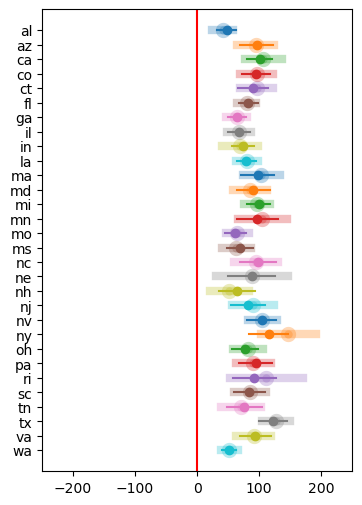

In [132]:
plt.figure(figsize=(4,6))

for j, i in enumerate(argsort_se):
    se2 = np.diag(Vs_ns[i])[-1]
    if se2 > 0:
        plt.plot(np.array([ths_ns[i,-1]-chi_pa*np.sqrt(se2), 
                  ths_ns[i,-1]+chi_pa*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i, alpha=0.3, linewidth=6)
    else:
        plt.axhline(y=j, color='C%d'%i, alpha=0.3, linewidth=6)
    plt.scatter(ths_ns[i,-1]*(-20), j, color='C%d'%i, alpha=0.3, linewidth=5)

    se2 = np.diag(Vs_ml[i])[-1]
    if se2 > 0:
        plt.plot(np.array([ths_ml[i,-1]-chi_ml[i]*np.sqrt(se2), 
                  ths_ml[i,-1]+chi_ml[i]*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i)
    else:
        plt.axhline(y=j, color='C%d'%i)
    plt.scatter(ths_ml[i,-1]*(-20), j, color='C%d'%i)

plt.axvline(x=0, color='red')
plt.yticks(np.arange(len(regions)), regions[argsort_se])
plt.xlim(-250,250)

plt.show()

## compare

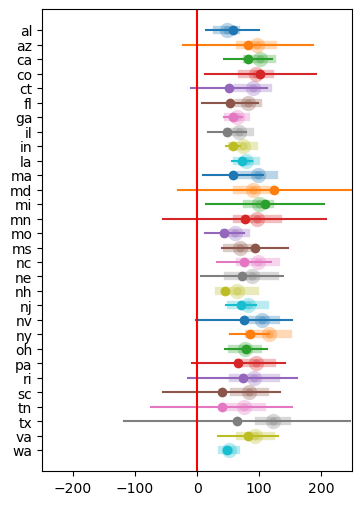

In [133]:
plt.figure(figsize=(4,6))

for j, i in enumerate(argsort_se):
    se2 = np.diag(Vs_ml[i])[-1]
    if se2 > 0:
        plt.plot(np.array([ths_ml[i,-1]-chi_ml[i]*np.sqrt(se2), 
                  ths_ml[i,-1]+chi_ml[i]*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i, alpha=0.3, linewidth=6)
    else:
        plt.axhline(y=j, color='C%d'%i, alpha=0.3, linewidth=6)
    plt.scatter(ths_ml[i,-1]*(-20), j, color='C%d'%i, alpha=0.3, linewidth=5)

    se2 = np.diag(Vs_eb[i])[-1]
    if se2 > 0:
        plt.plot(np.array([ths_eb[i,-1]-chi_eb[i]*np.sqrt(se2), 
                  ths_eb[i,-1]+chi_eb[i]*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i)
    else:
        plt.axhline(y=j, color='C%d'%i)
    plt.scatter(ths_eb[i,-1]*(-20), j, color='C%d'%i)

plt.axvline(x=0, color='red')
plt.yticks(np.arange(len(regions)), regions[argsort_se])
plt.xlim(-250,250)

plt.show()

In [137]:
np.sum(ths_ml[:,-1] < ths_eb[:,-1])

24

In [138]:
stats.binom.cdf(24, 30, 0.5)

0.9998375428840518